In [1]:
import sys
sys.path.append('..')

from bitarray import bitarray
import time
import os
import matplotlib.pyplot as plt
import pandas as pd
import math
import navbench as nb
import numpy as np
from scipy.spatial import distance
import utm
import shutil
from math import sqrt
from joblib import Parallel, delayed
import pickle
import csv


In [2]:
def dct_hash(im): 
    imf = np.float32(im)/255.0
    dst = cv2.dct(imf)
    img8 = dst[0:8,0:8]
    median = np.median(img8)
    imghash1 = img8 >= median 
    #np.asarray(imghash1, dtype=np.uint64)
    imghash1 = [y for x in imghash1 for y in x]
    imghash1 = bitarray(imghash1)
    return imghash1

def hash_distance(hash1, hash2) :
    return (hash1 ^ hash2).count()

def ridf_dct(snapshots, query_hash) :
    dist_rotations = []
    for rotation in snapshots :
        dist = (rotation^query_hash).count()
        dist_rotations.append(dist)
    return dist_rotations


def hash_distance_vector(reference_hash_list, query_hash) :
    dist_vector = [] 

    for snapshot in reference_hash_list : 
        dist_rotations = ridf_dct(snapshot,query_hash)
        dist_vector.append(dist_rotations)
       
    dist_vector = np.asarray(dist_vector) 
    ind = np.unravel_index(np.argmin(dist_vector, axis=None), dist_vector.shape)

    return dist_vector, ind 


# comparing routes with dct 
def get_rotations(im, total_rotations = 60) :
    length = len(im[0])
    skiprot = int(length/total_rotations)

    rotated_ims = []
    for rot in range(0, length, skiprot) :
        rotated = np.roll(im, -rot, axis=1)
        rotated_ims.append(rotated)
    return rotated_ims

def angle_diff(a, b) :
    return 180 - math.fabs(math.fmod(math.fabs(a - b), 2*180) - 180)

def get_rothashes(im) :
    im_rots = get_rotations(im)
    rotated_hashes = []
    for r in im_rots : 
        rotated_hashes.append(dct_hash(r))
    return rotated_hashes
    

def create_training_matrix(reference_imgs) :
    print("creating matrix")
    hash_ref_matrix = []
    for im in range(0, len(reference_imgs))  :
        if im % 100 == 0 : 
            print('processing image : ' + str(im) + '/'+str(len(reference_imgs)))
        rotated_hashes = get_rothashes(reference_imgs[im])
        hash_ref_matrix.append(rotated_hashes)
    return hash_ref_matrix


def getBest(hash_matrix, query_hash) :

    results = nb.imgproc.hash_distance_vector(hash_matrix, query_hash)
    return results

def read_database(path, width=180, height=46) :
    print('processing: ' + path)
    db = nb.Database(path)
    h_ims = db.read_images(preprocess=[nb.imgproc.histeq, nb.imgproc.resize(width,height) ])

    return db, h_ims

# gets all the images and converts them to image hash
def pre_process_db(ims, db) :
    hashes = []
    for i in ims :
        hashes.append(dct_hash(i))
    return hashes

def get_closest(db_1, db_2, query) :

    j = 0
    pos1 = db_1.position[query] # position of query
    q = query
    distances = []

    # if position of query is nan, find next not nan
    while sum( np.isnan(pos1) ) > 0 :
        pos1 = db_1.position[query+j]
        j+=1
        q = query + j

    for i in range(0, len(db_2.position)) :
   
        pos2 = db_2.position[i]
        if sum(np.isnan(pos2)) == 0 :    
            
            dist_in_m = np.linalg.norm(pos2[0:2] - pos1[0:2] )* 1000  # distance in meters
            distances.append(dist_in_m)
        else : 
            distances.append(100000)
         
    m_id =  np.argmin(distances)
    #print(distances[m_id-150:m_id+150:15]) 
    #print('match id: ' + str(m_id) + ' distance = ' + str(distances[m_id]) ) 
    
    return m_id

def get_route_difference(db_1,db_2, query, rng=300) :
    "plot difference over length from goal"

    cl_num = get_closest(db_1,db_2, query)
    query_h = training_mat1[query][0]
    dists,ind = hash_distance_vector(training_mat2[cl_num-rng:cl_num+rng], query_h )
    min_dist = np.argmin(dists)
    return dists

def get_route_difference_pm(db_1, db_2, query, rng=300) :
    cl_num = get_closest(db_1,db_2, query)
    query_im = h_images2[query]

    ridf_pm = nb.navigation.ridf(h_images1[cl_num-rng:cl_num+rng], h_images2[q_cl],step=3)
    dists =nb.navigation.route_ridf(h_images1[cl_num-rng:cl_num+rng], query_im, step=3)
    return dists, ridf_pm

def get_difference_image() :
    ""


In [3]:
dbnum = 0
file_to_depickle =  'db'+str(dbnum)+'_images_180x46_w_hist'
db_to_load = open(file_to_depickle, "rb")
curr_db = pickle.load(db_to_load)

dbnum = 1
file_to_depickle2 =  'db'+str(dbnum)+'_images_180x46_w_hist'
db_to_load2 = open(file_to_depickle2, "rb")
curr_db2 = pickle.load(db_to_load2)

print('database loaded')

db1 = curr_db[0]
h_images1 = curr_db[1]
h_hashes = curr_db[2]
training_mat1 = curr_db[3]
meta1 = db1.metadata

db2 = curr_db2[0]
h_images2 = curr_db2[1]
h_hashes = curr_db[2]
training_mat2 = curr_db2[3]
meta2 = db2.metadata


database loaded


bitarray('1101000010000100011011011010011011011110111000110011001110011000')

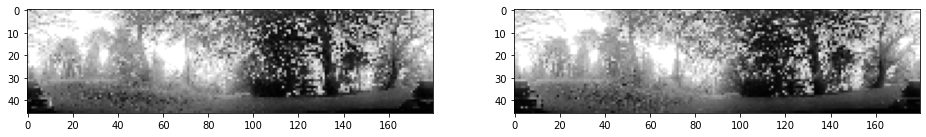

In [6]:
q_cl = 600
cl_num = get_closest(db1,db2, q_cl)
plt.rcParams["figure.figsize"] = (16,6)
fig, ax = plt.subplots(1,2)
ax[0].imshow(h_images1[q_cl],cmap='gray')
ax[1].imshow(h_images2[cl_num],cmap='gray')
#ax[2].imshow(images2[cl_num+100],cmap='gray')


[-180, -180, -120, -60, 0, 60, 120, 60.0]


/tmp/ipykernel_602737/717341921.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([-180,-90,0,90,180])
/tmp/ipykernel_602737/717341921.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(curr_ticks)


(-0.5, 399.5, 59.5, -0.5)

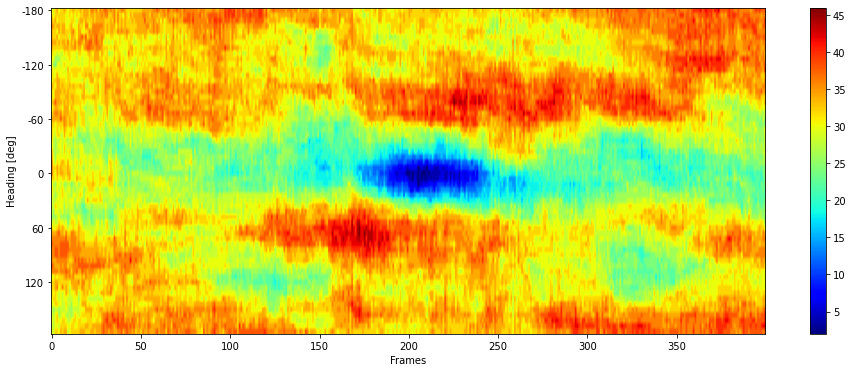

In [61]:

skip = 1
range_n = 200
route_diffs = get_route_difference(db1,db2, q_cl, rng=range_n)
rd,_ = get_route_difference_pm(db1,db2, q_cl,rng=range_n)
fig, ax = plt.subplots()
rdt = route_diffs.transpose()
rdt_rolled = np.roll(rdt, 30, axis=0)
imgsh = ax.imshow(rdt_rolled[:,::skip], cmap='jet')
#x.set_yticklabels(np.arange(-180,180, 1))
ax.set_yticklabels([-180,-90,0,90,180])
curr_ticks =ax.get_yticks().tolist()
curr_ticks[0] = -180
curr_ticks[1] = -180
curr_ticks[2] = -120
curr_ticks[3] = -60
curr_ticks[4] = 0
curr_ticks[5] = 60
curr_ticks[6] = 120

ax.set_yticklabels(curr_ticks)
ax.set_ylabel('Heading [deg]')
ax.set_xlabel('Frames')
plt.colorbar(imgsh)
print(curr_ticks)
#ax.set_yticklabels([-180,-90,0,90,180])
ax.axis('auto')


/tmp/ipykernel_602737/2365144406.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(new_xticks)
/tmp/ipykernel_602737/2365144406.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(curr_ticks2)


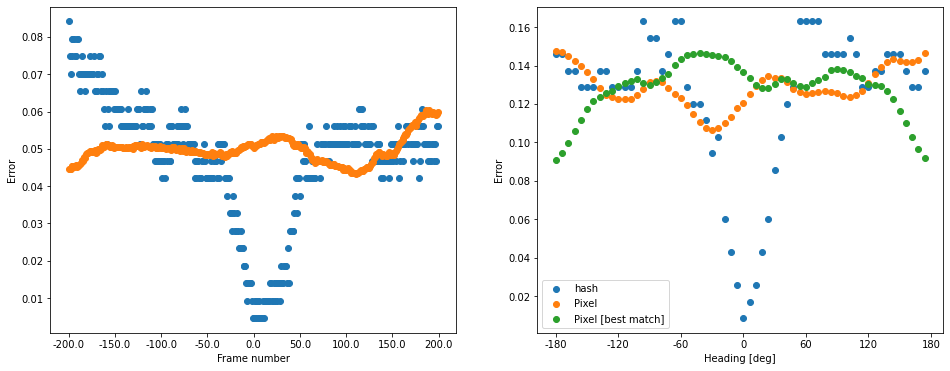

In [62]:
fig, ax = plt.subplots(1,2)

pl1 = route_diffs.transpose()[0]
pl2 = np.roll(route_diffs[range_n],30)

std_hash_diff  = pl1 / np.sqrt(np.sum(pl1**2))
std_pm_diff = rd.transpose() / np.sqrt(np.sum(rd.transpose()**2))
#ax[0].plot(route_diffs.transpose()[0])
#ax[0].plot(rd.transpose())
#ax[0].plot(std_hash_diff, label='hash')
#ax[0].plot(std_pm_diff, label='pixel')
ax[0].scatter(range(0,len(std_hash_diff)),std_hash_diff,label='hash')
ax[0].scatter(range(0,len(std_pm_diff)),std_pm_diff,label='pixel')


ax[1].set_xlabel('Heading [deg]')
ax[1].set_ylabel('Error')
ax[0].set_xlabel('Frame number')
ax[0].set_ylabel('Error')
curr_ticks_diff =ax[0].get_xticks().tolist()
new_xticks = np.asarray(curr_ticks_diff)-range_n
ax[0].set_xticklabels(new_xticks)

# setting xlabels 
curr_ticks2 = np.ndarray((8,),int)
curr_ticks2[0] = -180
curr_ticks2[1] = -180
curr_ticks2[2] = -120
curr_ticks2[3] = -60
curr_ticks2[4] = 0
curr_ticks2[5] = 60
curr_ticks2[6] = 120
curr_ticks2[7] = 180
ax[1].set_xticklabels(curr_ticks2)


#dists, ridf_pm =nb.navigation.route_ridf(im_rots, images1[q_cl], step=6)
dists, ridf_pm = get_route_difference_pm(db1, db2, q_cl)
pm_b_match = np.argmin(dists)
std_ridf_pm_bm = ridf_pm[pm_b_match] / np.sqrt(np.sum(ridf_pm[pm_b_match]**2))

std_ridf_pm_match = dists[pm_b_match] / np.sqrt(np.sum(dists[pm_b_match]**2))
std_ridf_hash  = pl2 / np.sqrt(np.sum(pl2**2))
std_ridf_pm = ridf_pm[range_n] / np.sqrt(np.sum(ridf_pm[range_n]**2))
plt_ridf = np.roll(std_ridf_pm,30)
ax[1].scatter(range(0,len(std_ridf_hash)),std_ridf_hash,label='hash')
ax[1].scatter(range(0,len(plt_ridf)),plt_ridf, label='Pixel') # ridf at the best
ax[1].scatter(range(0,len(std_ridf_pm_bm)),std_ridf_pm_bm, label='Pixel [best match]')
plt.legend()



In [150]:
len(std_ridf_pm)

60

In [63]:
""

''

In [48]:
'index col, best match, closest loc index, best match rotation, value of idf at that point in rotation, rotation of the closest location match  and its idf' ' and all parameters '

11846

database loaded


In [9]:
def simulate_route(database_1_num, database_2_num, skipframe_h, skipframe_pm, query_step, db1_start=0, db1_end=-1, db2_start=0, db2_end=-1) :
    dbnum = database_1_num
    file_to_depickle =  'db'+str(dbnum)+'_images_180x46_w_hist'
    db_to_load = open(file_to_depickle, "rb")
    curr_db = pickle.load(db_to_load)

    dbnum = database_2_num
    file_to_depickle2 =  'db'+str(dbnum)+'_images_180x46_w_hist'
    db_to_load2 = open(file_to_depickle2, "rb")
    curr_db2 = pickle.load(db_to_load2)

    print('database loaded')

    db1 = curr_db[0]
    h_images1 = curr_db[1]
    training_mat1 = curr_db[3]
    meta1 = db1.metadata

    db2 = curr_db2[0]
    h_images2 = curr_db2[1]
    training_mat2 = curr_db2[3]
    meta2 = db2.metadata

    print(meta1)

    print(meta2)

    scores = []
    confidence_score_hash = []
    confidence_score_pm = []
    scores_pm = []
    traj_plot_hash = []

 
    results_hash_pm_true = []

    
    for q in range(db1_start,len(training_mat1),query_step) :

        if (q >= db1_end) and (db1_end > 0):
            break
        pos1 = db1.position[q]
        query_h = training_mat1[q][0]

        closest_ind = get_closest(db_1=db1,db_2=db2, query=q)


        j = 0
        while sum( np.isnan(pos1) ) > 0 :
            query_h = training_mat1[q+j][0]
            pos1 = db1.position[q+j]
            j+=1

        traj_plot_hash.append(pos1) # append position to list if it had a valid coordinate
        
        dists,ind = hash_distance_vector(training_mat2[db2_start:db2_end:skipframe_h], query_h )

        pos2 = db2.position[ind[0]*skipframe_h]
        i = 0
        while sum(np.isnan(pos2)) > 0 :    
            pos2 = db2.position[ind[0]+i]
            i+=1

        dist_in_m = np.linalg.norm(pos1[0:1] - pos2[0:1] )
        scores.append(dist_in_m*100)

        # pixel matching
        
        #pm_match =nb.navigation.route_ridf(h_images2[db2_start:db2_end:skipframe_pm], h_images1[q], step=6)
        pm_match =nb.navigation.route_ridf(h_images2[db2_start:db2_end:skipframe_pm], h_images1[q], step=6)
        pm_match_index =  np.argmin(pm_match)
        pos_pm = db2.position[pm_match_index*skipframe_pm]

        k = 0
        while sum(np.isnan(pos_pm)) > 0 :    
            pos_pm = db2.position[pm_match_index+k]
            k+=1
        dist_pm = np.linalg.norm(pos1[0:1] - pos_pm[0:1] )
        scores_pm.append(dist_pm*100)

        results_hash_pm_true.append([q, ind[0]*skipframe_h, pm_match_index*skipframe_pm, closest_ind])
    
    return scores, scores_pm, traj_plot_hash, meta1, meta2, results_hash_pm_true

In [10]:
dnum1 = 3
dnum2 = 9
scores, scores_pm, traj_plot_hash, meta1, meta2, results  = simulate_route(dnum1, dnum2, 1, 5, 15, db1_start=5000, db1_end=6000, db2_start=4000, db2_end=7000) 

database loaded
{'type': 'route', 'camera': {'name': 'pixpro_usb', 'resolution': [1440, 1440], 'isPanoramic': 1}, 'needsUnwrapping': 0, 'isGreyscale': 0, 'firstImage': 125, 'lastImage': 10384, 'weather': 'cloudy', 'date': {'day': 3, 'month': 3, 'year': 2021, 'hour': 15, 'minute': 37}}
{'type': 'route', 'camera': {'name': 'pixpro_usb', 'resolution': [1440, 1440], 'isPanoramic': 1}, 'needsUnwrapping': 0, 'isGreyscale': 0, 'firstImage': 335, 'lastImage': 11680, 'weather': 'sunny', 'date': {'day': 20, 'month': 4, 'year': 2021, 'hour': 13, 'minute': 57}}


In [12]:
results

[[(282, 39), 407, 4764],
 [(895, 1), 406, 4771],
 [(760, 0), 414, 4788],
 [(698, 6), 406, 4788],
 [(806, 0), 406, 4795],
 [(605, 15), 406, 4844],
 [(910, 0), 406, 4883],
 [(909, 1), 406, 4883],
 [(937, 1), 536, 4886],
 [(933, 58), 385, 4958],
 [(896, 1), 406, 4982],
 [(1193, 13), 406, 5003],
 [(16, 0), 406, 5003],
 [(1111, 58), 406, 5003],
 [(1013, 0), 539, 5004],
 [(1069, 5), 539, 5004],
 [(1063, 2), 539, 5018],
 [(1066, 2), 539, 5076],
 [(1066, 2), 406, 5081],
 [(1070, 5), 513, 5085],
 [(1038, 59), 511, 5085],
 [(1059, 1), 539, 5085],
 [(1033, 54), 539, 5085],
 [(1644, 5), 545, 5090],
 [(1066, 0), 539, 5091],
 [(1034, 56), 539, 5091],
 [(1109, 56), 539, 5097],
 [(1111, 0), 539, 5097],
 [(975, 8), 539, 5097],
 [(311, 36), 518, 5097],
 [(1126, 5), 520, 5097],
 [(1140, 3), 539, 5099],
 [(1151, 57), 535, 5111],
 [(180, 52), 418, 5123],
 [(111, 24), 539, 5123],
 [(1186, 59), 409, 5138],
 [(1196, 2), 558, 5148],
 [(1193, 2), 564, 5148],
 [(1219, 57), 511, 5148],
 [(1211, 0), 407, 5206],
 [

/tmp/ipykernel_685987/3607612654.py:51: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(map1)


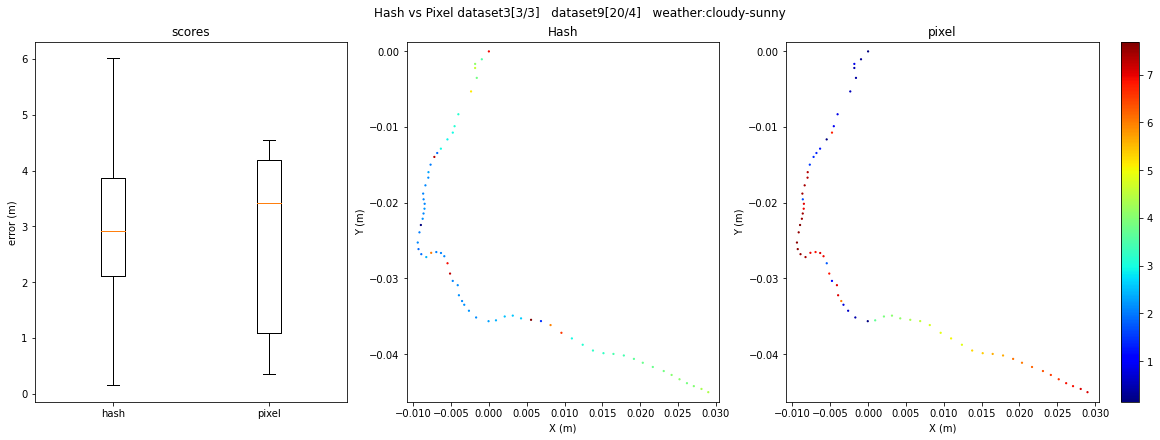

In [11]:
fig, ax = plt.subplots(1,3,constrained_layout=True)
#plt.rcParams["figure.figsize"] = (5,4)
#ax.boxplot([scores,scores_pm],showfliers=False)
plot_label = "Acc(5m)=" +str(sum(np.asarray(scores) < 5)/len(scores))
plot_label_pm = "Acc(5m)=" +str(sum(np.asarray(scores_pm) < 5)/len(scores_pm))
ax[0].boxplot([scores,scores_pm],showfliers=False)
ax[0].set_xticklabels(['hash','pixel'])
ax[0].set_ylabel('error (m)')
#ax[0].axis('equal')
ax[1].axis('equal')
ax[2].axis('equal')

m1d = meta1['date']['day']
m1m = meta1['date']['month']

m2d = meta2['date']['day']
m2m = meta2['date']['month']

positions = np.asarray(traj_plot_hash)[:,0:2]

pos_zero = positions[0]
positions_std = positions - pos_zero

scores_thresh = 25
scores_plot = []
for i in scores :
    if i > scores_thresh :
        scores_plot.append(scores_thresh)
    else :
        scores_plot.append(i)

scores_plot_pm = []
for i in scores_pm :
    if i > scores_thresh :
        scores_plot_pm.append(scores_thresh)
    else :
        scores_plot_pm.append(i)

fig.suptitle('Hash vs Pixel' +  ' dataset' + str(dnum1) + '[' + str(m1d) + '/' + str(m1m) + ']  '
 + ' dataset' + str(dnum2)  + '[' + str(m2d) + '/' + str(m2m) + ']  ' + " weather:"+(str(meta1['weather']) )+ '-' +str(meta2['weather']), fontsize=12)
map1 = ax[1].scatter(positions_std[:,0], positions_std[:,1],s=1.5,c=scores_plot,cmap='jet')
map2 = ax[2].scatter(positions_std[:,0], positions_std[:,1],s=1.5,c=scores_plot_pm,cmap='jet')
ax[0].set_title('scores')
#ax[0].set_ylimit(50)
ax[1].set_title('Hash')
ax[2].set_title('pixel')
ax[1].set_ylabel('Y (m)')
ax[2].set_xlabel('X (m)')
ax[2].set_ylabel('Y (m)')
ax[1].set_xlabel('X (m)')
fig.colorbar(map1)


0.0759493670886076

In [17]:
""

''

In [66]:
db2.metadata

{'type': 'route',
 'camera': {'name': 'pixpro_usb',
  'resolution': [1440, 1440],
  'isPanoramic': 1},
 'needsUnwrapping': 0,
 'isGreyscale': 0,
 'firstImage': 110,
 'lastImage': 11870,
 'weather': 'sunny',
 'date': {'day': 11, 'month': 5, 'year': 2021, 'hour': 15, 'minute': 39}}

array([-180, -177, -174, -171, -168, -165, -162, -159, -156, -153, -150,
       -147, -144, -141, -138, -135, -132, -129, -126, -123, -120, -117,
       -114, -111, -108, -105, -102,  -99,  -96,  -93,  -90,  -87,  -84,
        -81,  -78,  -75,  -72,  -69,  -66,  -63,  -60,  -57,  -54,  -51,
        -48,  -45,  -42,  -39,  -36,  -33,  -30,  -27,  -24,  -21,  -18,
        -15,  -12,   -9,   -6,   -3,    0,    3,    6,    9,   12,   15,
         18,   21,   24,   27,   30,   33,   36,   39,   42,   45,   48,
         51,   54,   57,   60,   63,   66,   69,   72,   75,   78,   81,
         84,   87,   90,   93,   96,   99,  102,  105,  108,  111,  114,
        117,  120,  123,  126,  129,  132,  135,  138,  141,  144,  147,
        150,  153,  156,  159,  162,  165,  168,  171,  174,  177])